## 2. Uczenie głębokie

In [1]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import keras
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, GlobalAveragePooling2D, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
import matplotlib.pyplot as plt
import sklearn
import sklearn.metrics

In [2]:
EPOCHS = 18
BATCH_SIZE = 32
STEPS_PER_EPOCH = 32
VALIDATION_STEPS = 32
LEARNING_RATE = 0.001
###zadanie-nr-epochs-batch_size-learning-rate
MODEL_FILE = 'models/ex-2a-18-32-1e-3.model'
##selected classses
classes = ["Lemon", "Raspberry", "Mandarine", "Pear 2", "Apple Red 1", "Strawberry", "Pomegranate", "Pepino", "Kaki", "Apricot", "Ginger Root", "Huckleberry"]

In [3]:
trdata_gen = ImageDataGenerator(rescale=1./255)
traindata = trdata_gen.flow_from_directory(directory="../data/Training",target_size=(224,224), batch_size=1,color_mode="rgb", shuffle=True,classes=classes,class_mode="categorical") 

Found 9796 images belonging to 12 classes.


In [4]:
# traindata.reset()
x_train=np.concatenate([traindata.next()[0] for i in range(traindata.__len__())])
y_train=np.concatenate([traindata.next()[1] for i in range(traindata.__len__())])
print(x_train.shape)
print(y_train.shape)

(9796, 224, 224, 3)
(9796, 12)


In [5]:
tsdata_gen = ImageDataGenerator(rescale=1./255)
testdata = tsdata_gen.flow_from_directory(directory="../data/Test",shuffle=False, target_size=(224,224), batch_size=1,color_mode="rgb", classes=classes,class_mode="categorical")

Found 1981 images belonging to 12 classes.


In [6]:
testdata.reset()
x_test=np.concatenate([testdata.next()[0] for i in range(testdata.__len__())])
y_test=np.concatenate([testdata.next()[1] for i in range(testdata.__len__())])
print(x_test.shape)
print(y_test)
print(np.argmax(y_test, axis=1))

(1981, 224, 224, 3)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
[ 0  0  0 ... 11 11 11]


In [7]:
print(y_test)
print(np.argmax(y_test, axis=1))

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
[ 0  0  0 ... 11 11 11]


In [8]:
valdata_gen = ImageDataGenerator(rescale=1./255)
valdata = tsdata_gen.flow_from_directory(directory="../data/Validation",shuffle=True, target_size=(224,224), batch_size=1,color_mode="rgb", classes=classes,class_mode="categorical")

Found 1735 images belonging to 12 classes.


In [9]:
valdata.reset()
x_val=np.concatenate([valdata.next()[0] for i in range(valdata.__len__())])
y_val=np.concatenate([valdata.next()[1] for i in range(valdata.__len__())])
print(x_val.shape)
print(y_val.shape)

(1735, 224, 224, 3)
(1735, 12)


In [10]:
CLASSES = len(traindata.class_indices)
# CLASSES = 131

In [11]:
base_model = VGG16(weights='imagenet', include_top = False , input_shape=(224,224, 3))
print(base_model.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [12]:
##freeze all  base_model layers and train the last ones
for layer in base_model.layers:
    layer.trainable = False

In [13]:
checkpoint = ModelCheckpoint("ex-2a-18-32-1e-3.h5", monitor='val_acc', verbose=1, save_weights_only=False, mode='auto', period=1)
# early_stopper = EarlyStopping(monitor='val_acc', min_delta=0.001, patience=100, verbose=1, mode='auto')

2.1 Uczenie ostatniej warstwy splotowej i warstwy klasyfikującej

In [19]:
last_conv_flat = Flatten()(base_model.layers[-1].output)
# # add new classifier layers
class_dense_flat1 = Dense(4096, activation='relu')(last_conv_flat) 
class_dense_flat2 = Dense(4096, activation='relu')(class_dense_flat1) 
# -what about this
output = Dense(CLASSES, activation='softmax')(class_dense_flat2 )
# define new model
## maybe add dropout and maybe one more dense
last_conv_model = Model(inputs=base_model.inputs, outputs=output)
# summarize
last_conv_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [20]:
last_conv_model.get_layer('block5_conv3').trainable = True
last_conv_model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [16]:
print(len(traindata))
print(len(x_train))

9796
9796


In [17]:
opt = keras.optimizers.RMSprop(
    learning_rate=LEARNING_RATE,
    rho=0.9,
    momentum=0.0,
    epsilon=1e-07,
    centered=False,
    name="RMSprop",
)

In [18]:
last_conv_model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['acc'])
last_conv_model_history = last_conv_model.fit(
    traindata,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch=len(traindata)/BATCH_SIZE,
    validation_steps=len(valdata)//BATCH_SIZE,
    validation_data=valdata,
    shuffle=True,
    callbacks=[checkpoint],
    workers=-1, use_multiprocessing=False
)


last_conv_model.save(MODEL_FILE)

Epoch 1/30
306/306 [==============================] - 339s 1s/step - loss: 37.1756 - acc: 0.1255 - val_loss: 1.5089 - val_acc: 0.5000

Epoch 00001: saving model to ex-2-30-321-1e-3.h5
Epoch 2/30
306/306 [==============================] - 333s 1s/step - loss: 2.1747 - acc: 0.4693 - val_loss: 1.0892 - val_acc: 0.7222

Epoch 00002: saving model to ex-2-30-321-1e-3.h5
Epoch 3/30
306/306 [==============================] - 334s 1s/step - loss: 1.4271 - acc: 0.7530 - val_loss: 2.4265 - val_acc: 0.6296

Epoch 00003: saving model to ex-2-30-321-1e-3.h5
Epoch 4/30
306/306 [==============================] - 339s 1s/step - loss: 1.4282 - acc: 0.7345 - val_loss: 1.2934 - val_acc: 0.7037

Epoch 00004: saving model to ex-2-30-321-1e-3.h5
Epoch 5/30
306/306 [==============================] - 347s 1s/step - loss: 0.8577 - acc: 0.8125 - val_loss: 1.3752 - val_acc: 0.8519

Epoch 00005: saving model to ex-2-30-321-1e-3.h5
Epoch 6/30
306/306 [==============================] - 348s 1s/step - loss: 1.0413 - 

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


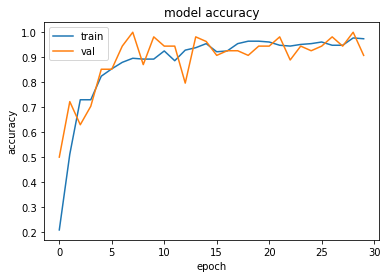

In [19]:
print(last_conv_model_history.history.keys())
plt.plot(last_conv_model_history.history['acc'])
plt.plot(last_conv_model_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('ex-2-30-321-1e-3.png')
plt.show()

In [10]:
last_conv_model = keras.models.load_model(MODEL_FILE)

In [11]:
last_conv_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [12]:
y_pred_train = last_conv_model.predict(x_train, workers=-1, use_multiprocessing=True, verbose=1)


307/307 [==============================] - 1746s 6s/step


In [13]:
print(sklearn.metrics.classification_report(np.argmax(y_train, axis=1), np.argmax( y_pred_train, axis=1)))

              precision    recall  f1-score   support

           0       0.98      0.86      0.92       815
           1       1.00      1.00      1.00       816
           2       1.00      0.75      0.86       814
           3       1.00      0.97      0.98       827
           4       0.87      0.97      0.92       818
           5       0.95      0.99      0.97       818
           6       0.88      0.98      0.93       818
           7       0.98      1.00      0.99       813
           8       1.00      0.92      0.96       815
           9       0.87      0.99      0.93       813
          10       0.94      1.00      0.97       810
          11       1.00      0.98      0.99       819

    accuracy                           0.95      9796
   macro avg       0.95      0.95      0.95      9796
weighted avg       0.96      0.95      0.95      9796



In [14]:
print(np.argmax( y_pred_train, axis=1))
print(np.argmax( y_train, axis=1))

[ 0  0  0 ... 11 11 11]
[ 0  0  0 ... 11 11 11]


In [15]:
y_pred_test = last_conv_model.predict(x_test, workers=3, use_multiprocessing=True, verbose=1, batch_size=1)
print(sklearn.metrics.classification_report(np.argmax(y_test, axis=1),np.argmax( y_pred_test, axis=1)))

1981/1981 [==============================] - 437s 220ms/step
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       164
           1       1.00      1.00      1.00       166
           2       1.00      0.53      0.69       166
           3       1.00      0.59      0.74       232
           4       0.54      1.00      0.71       164
           5       1.00      1.00      1.00       164
           6       0.71      1.00      0.83       164
           7       1.00      0.69      0.81       166
           8       1.00      0.80      0.89       166
           9       0.77      1.00      0.87       164
          10       1.00      1.00      1.00        99
          11       1.00      1.00      1.00       166

    accuracy                           0.87      1981
   macro avg       0.91      0.88      0.87      1981
weighted avg       0.91      0.87      0.87      1981



[ 0  0  0 ... 11 11 11]
[ 0  0  0 ... 11 11 11]
(1, 224, 224, 3) [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


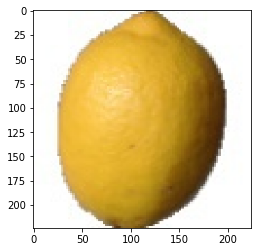

(1, 224, 224, 3) [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


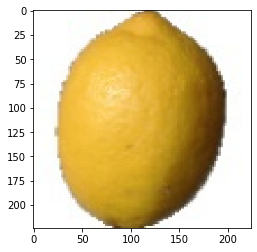

(1, 224, 224, 3) [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


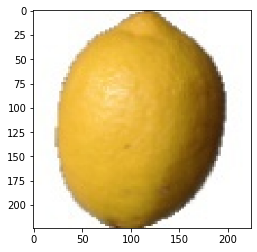

(1, 224, 224, 3) [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


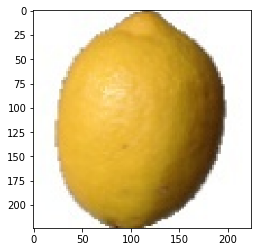

(1, 224, 224, 3) [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


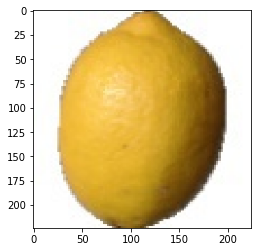

(1, 224, 224, 3) [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


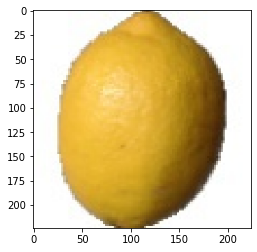

(1, 224, 224, 3) [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


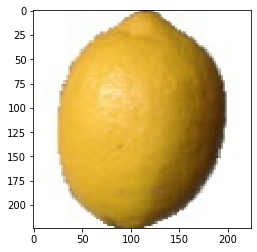

(1, 224, 224, 3) [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


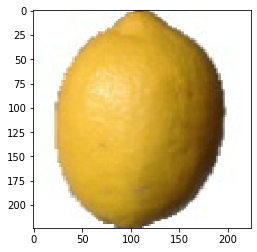

(1, 224, 224, 3) [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


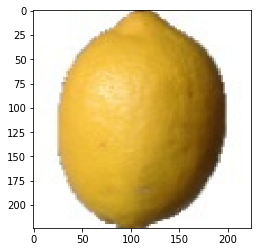

(1, 224, 224, 3) [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


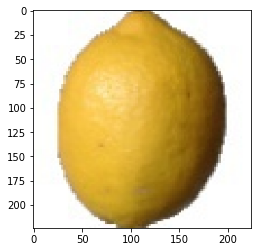

(1, 224, 224, 3) [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


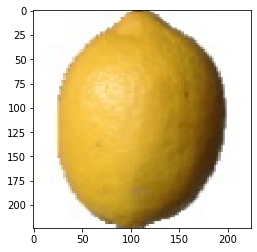

(1, 224, 224, 3) [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


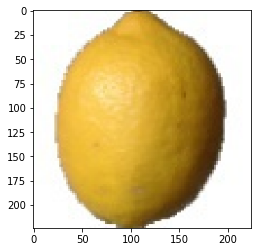

(1, 224, 224, 3) [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


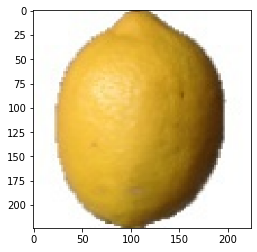

(1, 224, 224, 3) [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


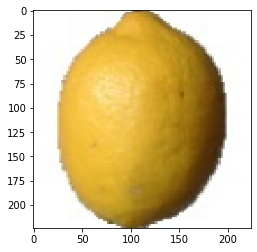

(1, 224, 224, 3) [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


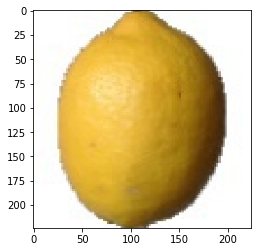

(1, 224, 224, 3) [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


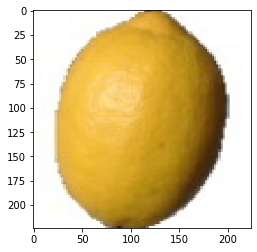

(1, 224, 224, 3) [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


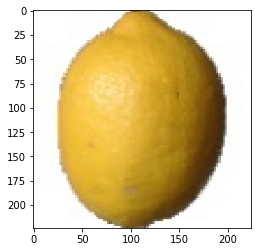

(1, 224, 224, 3) [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


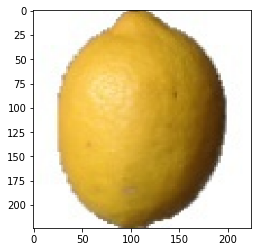

(1, 224, 224, 3) [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


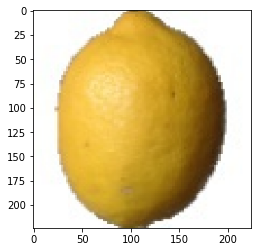

(1, 224, 224, 3) [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


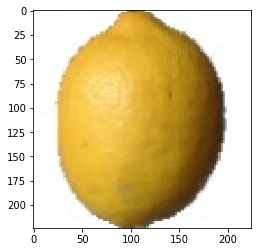

In [16]:
print(np.argmax( y_pred_test, axis=1))
print(np.argmax( y_test, axis=1))
for _ in range(20):
    img, label = testdata.next()
    print(img.shape, label)   #  (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

In [17]:

y_pred_val = last_conv_model.predict(valdata,batch_size=1, workers=-1, use_multiprocessing=True, verbose=1)
print(sklearn.metrics.classification_report(np.argmax(y_val, axis=1),np.argmax( y_pred_val, axis=1)))

1735/1735 [==============================] - 406s 234ms/step
              precision    recall  f1-score   support

           0       0.97      0.81      0.89       144
           1       1.00      0.99      0.99       145
           2       1.00      0.74      0.85       144
           3       1.00      0.96      0.98       146
           4       0.87      0.97      0.92       145
           5       0.92      0.97      0.94       145
           6       0.84      0.97      0.90       145
           7       0.99      1.00      0.99       144
           8       1.00      0.90      0.95       144
           9       0.82      0.99      0.90       144
          10       0.91      1.00      0.95       144
          11       1.00      0.96      0.98       145

    accuracy                           0.94      1735
   macro avg       0.94      0.94      0.94      1735
weighted avg       0.94      0.94      0.94      1735



2.2 Uczenie dwóch ostatnich warstw splotowych i warstwy klasyfikującej

In [17]:
two_last_conv_flat = Flatten()(base_model.layers[-1].output)
# # add new classifier layers
class_dense_flat1 = Dense(4096, activation='relu')(two_last_conv_flat) 
class_dense_flat2 = Dense(4096, activation='relu')(class_dense_flat1)
output = Dense(CLASSES, activation='softmax')(class_dense_flat2)
# define new model
## maybe add dropout and maybe one more dense
two_last_conv_model = Model(inputs=base_model.inputs, outputs=output)
# summarize
two_last_conv_model.summary()
 # add new classifier layers
# -what about this


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [18]:
two_last_conv_model.get_layer('block5_conv3').trainable = True
two_last_conv_model.get_layer('block5_conv2').trainable = True
two_last_conv_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [19]:
opt = keras.optimizers.RMSprop(
    learning_rate=LEARNING_RATE,
    rho=0.9,
    momentum=0.0,
    epsilon=1e-07,
    centered=False,
    name="RMSprop",
)

In [ ]:
two_last_conv_model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['acc'])
two_last_conv_model_history = two_last_conv_model.fit(
    traindata,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch=len(traindata)/BATCH_SIZE,
    validation_steps=len(valdata)//BATCH_SIZE,
    validation_data=valdata,
    shuffle=True,
    callbacks=[checkpoint],
    workers=-1, use_multiprocessing=True
)


model.save(MODEL_FILE)

Epoch 1/18
306/306 [==============================] - 336s 1s/step - loss: 46.0936 - acc: 0.0951 - val_loss: 2.5016 - val_acc: 0.0185

Epoch 00001: saving model to ex-2a-18-32-1e-3.h5
Epoch 2/18
306/306 [==============================] - 350s 1s/step - loss: 2.4897 - acc: 0.0816 - val_loss: 2.5001 - val_acc: 0.0741

Epoch 00002: saving model to ex-2a-18-32-1e-3.h5
Epoch 3/18
306/306 [==============================] - 342s 1s/step - loss: 2.4863 - acc: 0.1059 - val_loss: 2.4765 - val_acc: 0.1111

Epoch 00003: saving model to ex-2a-18-32-1e-3.h5
Epoch 4/18
306/306 [==============================] - 340s 1s/step - loss: 2.4858 - acc: 0.1036 - val_loss: 2.4927 - val_acc: 0.0185

Epoch 00004: saving model to ex-2a-18-32-1e-3.h5
Epoch 5/18
306/306 [==============================] - 349s 1s/step - loss: 2.4887 - acc: 0.0886 - val_loss: 2.4776 - val_acc: 0.0926

Epoch 00005: saving model to ex-2a-18-32-1e-3.h5
Epoch 6/18
306/306 [==============================] - 344s 1s/step - loss: 2.4873 - 

In [ ]:
print(two_last_conv_model_history.history.keys())
plt.plot(two_last_conv_model.history['acc'])
plt.plot(two_last_conv_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('ex-2a-18-32-1e-3.png')
plt.show()

In [ ]:
y_pred_train =two_last_conv_model_history.predict(x_train, workers=-1, use_multiprocessing=True, verbose=1)
print(sklearn.metrics.classification_report(np.argmax(y_train, axis=1), np.argmax( y_pred_train, axis=1)))

In [ ]:
y_pred_test =two_last_conv_model_history.predict(x_test, workers=3, use_multiprocessing=True, verbose=1, batch_size=1)
print(sklearn.metrics.classification_report(np.argmax(y_test, axis=1),np.argmax( y_pred_test, axis=1)))

In [ ]:

y_pred_val = two_last_conv_model_history.predict(valdata,batch_size=1, workers=-1, use_multiprocessing=True, verbose=1)
print(sklearn.metrics.classification_report(np.argmax(y_val, axis=1),np.argmax( y_pred_val, axis=1)))

2.3 Uczenie całej sieci

In [ ]:
base_model = VGG16(weights='imagenet', include_top = True , input_shape=(224,224, 3))
print(base_model.summary())

2.4 Uproszczenie struktury